In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.spatial.distance import cdist
# from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from pyspark import SparkContext, SparkConf
import seaborn as sns

Read Data

In [3]:
# read data
file_path = 'songs.csv'
def read_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Data read successfully.")
        return df
    except Exception as e:
        print("Error reading data:", str(e))
        return None

In [4]:
df = read_data(file_path)
# df = df_all.sample(n=500, random_state=42)

Data read successfully.


/var/folders/_6/p6rbnzf53qqc6zhb68fmkftm0000gn/T/ipykernel_7179/3842736201.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Preprocessing and Data Exploration

In [5]:
# function to check which features to drop
def calculate_similarity_percentage(df):
    similarity_percentages = {}
    total_rows = len(df)
    for column in df.columns:
        most_frequent_count = df[column].value_counts(dropna=False).iloc[0]
        similarity_percentage = most_frequent_count / total_rows
        similarity_percentages[column] = similarity_percentage
    return similarity_percentages


In [6]:
similarity_percentages = calculate_similarity_percentage(df)
print("Similarity percentages:")
for column, percentage in similarity_percentages.items():
    print(f"{column}: {percentage*100:.2f}%")

Similarity percentages:
danceability: 0.45%
energy: 0.44%
key: 17.82%
loudness: 0.05%
mode: 54.95%
speechiness: 0.29%
acousticness: 0.18%
instrumentalness: 26.74%
liveness: 1.60%
valence: 0.27%
tempo: 0.14%
type: 100.00%
id: 0.02%
uri: 0.02%
track_href: 0.02%
analysis_url: 0.02%
duration_ms: 0.25%
time_signature: 95.56%
genre: 13.89%
song_name: 49.13%
Unnamed: 0: 50.88%
title: 50.88%


In [7]:
# remove the frequent features
def remove_high_similarity_columns(df, similarity_percentages, threshold=15):
    removed_columns = []
    for column, percentage in similarity_percentages.items():
        if percentage > threshold / 100:
            df.drop(columns=column, inplace=True)
            removed_columns.append(column)
    
    return df, removed_columns


In [8]:
df_preprocessed, removed_columns = remove_high_similarity_columns(df, similarity_percentages)
print("Removed columns:", removed_columns)


Removed columns: ['key', 'mode', 'instrumentalness', 'type', 'time_signature', 'song_name', 'Unnamed: 0', 'title']


In [9]:
# feature normalization
def remove_url_prefix(df):
    df['track_href'] = df['track_href'].str.replace('https://api.spotify.com/v1/tracks/', '', regex=False)
    df['analysis_url'] = df['analysis_url'].str.replace('https://api.spotify.com/v1/audio-analysis/', '', regex=False)
    df['uri'] = df['uri'].str.replace('spotify:track:', '', regex=False)
    return df

df_preprocessed = remove_url_prefix(df)
df_preprocessed.head()


danceability  energy  loudness  speechiness  acousticness  liveness  \
0         0.831   0.814    -7.364       0.4200        0.0598    0.0556   
1         0.719   0.493    -7.230       0.0794        0.4010    0.1180   
2         0.850   0.893    -4.783       0.0623        0.0138    0.3720   
3         0.476   0.781    -4.710       0.1030        0.0237    0.1140   
4         0.798   0.624    -7.668       0.2930        0.2170    0.1660   

   valence    tempo                      id                     uri  \
0   0.3890  156.985  2Vc6NJ9PW9gD9q343XFRKx  2Vc6NJ9PW9gD9q343XFRKx   
1   0.1240  115.080  7pgJBLVz5VmnL7uGHmRj6p  7pgJBLVz5VmnL7uGHmRj6p   
2   0.0391  218.050  0vSWgAlfpye0WCGeNmuNhy  0vSWgAlfpye0WCGeNmuNhy   
3   0.1750  186.948  0VSXnJqQkwuH2ei1nOQ1nu  0VSXnJqQkwuH2ei1nOQ1nu   
4   0.5910  147.988  4jCeguq9rMTlbMmPHuO7S3  4jCeguq9rMTlbMmPHuO7S3   

               track_href            analysis_url  duration_ms      genre  
0  2Vc6NJ9PW9gD9q343XFRKx  2Vc6NJ9PW9gD9q343XFRKx       124539  Dark Trap  
1  7pgJBLVz5VmnL7uGHmRj6p  7pgJBLVz5VmnL7uGHmRj6p       224427  Dark Trap  
2  0vSWgAlfpye0WCGeNmuNhy  0vSWgAlfpye0WCGeNmuNhy        98821  Dark Trap  
3  0VSXnJqQkwuH2ei1nOQ1nu  0VSXnJqQkwuH2ei1nOQ1nu       123661  Dark Trap  
4  4jCeguq9rMTlbMmPHuO7S3  4jCeguq9rMTlbMmPHuO7S3       123298  Dark Trap

In [10]:
# drop the coluns that have become the same, after some normalizations
# also drop duration as it doesnt seem to be that much relavant to our goal
drop = ['track_href','uri', 'analysis_url', 'duration_ms']
df_preprocessed = df_preprocessed.drop(columns=drop)
# drop genre column as we want to use it as target column in the output
genre_drop = ['genre']
df_preprocessed_done = df_preprocessed.drop(columns=genre_drop)
df_preprocessed_done.head()

danceability  energy  loudness  speechiness  acousticness  liveness  \
0         0.831   0.814    -7.364       0.4200        0.0598    0.0556   
1         0.719   0.493    -7.230       0.0794        0.4010    0.1180   
2         0.850   0.893    -4.783       0.0623        0.0138    0.3720   
3         0.476   0.781    -4.710       0.1030        0.0237    0.1140   
4         0.798   0.624    -7.668       0.2930        0.2170    0.1660   

   valence    tempo                      id  
0   0.3890  156.985  2Vc6NJ9PW9gD9q343XFRKx  
1   0.1240  115.080  7pgJBLVz5VmnL7uGHmRj6p  
2   0.0391  218.050  0vSWgAlfpye0WCGeNmuNhy  
3   0.1750  186.948  0VSXnJqQkwuH2ei1nOQ1nu  
4   0.5910  147.988  4jCeguq9rMTlbMmPHuO7S3

In [11]:
# check if any null values exist
def count_null_values(df):
    null_counts = df.isnull().sum()
    return null_counts

null_counts = count_null_values(df_preprocessed_done)
print("Null value counts for each column:")
print(null_counts)

Null value counts for each column:
danceability    0
energy          0
loudness        0
speechiness     0
acousticness    0
liveness        0
valence         0
tempo           0
id              0
dtype: int64


In [12]:
# encode genre to numerical values
def encode_genre(df):
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    df_encoded['genre_encoded'] = label_encoder.fit_transform(df['genre'])
    genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    return df_encoded, genre_mapping


In [13]:
# df_preprocessed_encoded, genre_mapping = encode_genre(df_preprocessed)
# print("Genre mapping:")
# print(genre_mapping)

In [14]:
# genre labels
genres = df_preprocessed['genre'].values 
genres

array(['Dark Trap', 'Dark Trap', 'Dark Trap', ..., 'hardstyle',
       'hardstyle', 'hardstyle'], dtype=object)

CURE Algorithm Implementation

In [15]:
def hierarchical_clustering(sample, num_clusters):
    # Initialize each point as a cluster
    clusters = [[point] for point in sample]
    
    while len(clusters) > num_clusters:
        min_dist = float('inf')
        merge_i, merge_j = -1, -1

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = np.linalg.norm(np.mean(clusters[i], axis=0) - np.mean(clusters[j], axis=0))
                if dist < min_dist:
                    min_dist = dist
                    merge_i, merge_j = i, j

        merged_cluster = clusters[merge_i] + clusters[merge_j]
        clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
        clusters.append(merged_cluster)
        
        # Check if the number of clusters has reached the desired value
        if len(clusters) == num_clusters:
            break
    
    return [np.array(cluster) for cluster in clusters]

def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((np.array(point) - np.array(centroid)) ** 2))

# Pass 1: Initial clustering and selecting representatives
def pass_one(data, sample_size, num_clusters, alpha):
    sample_indices = np.random.choice(data.shape[0], sample_size, replace=False)
    sample = data[sample_indices]

    initial_clusters = hierarchical_clustering(sample, num_clusters)
    representatives = []

    for cluster in initial_clusters:
        centroid = np.mean(cluster, axis=0)
        dispersed_representatives = select_dispersed_representatives(cluster, alpha)
        moved_representatives = move_representatives_towards_centroid(dispersed_representatives, centroid, alpha)
        representatives.append(moved_representatives)

    return initial_clusters, representatives

# Select dispersed representatives for each cluster
def select_dispersed_representatives(cluster, alpha):
    num_points = len(cluster)
    num_representatives = int(num_points * alpha)
    if num_representatives == 0:
        num_representatives = 1
    return cluster[np.linspace(0, num_points - 1, num_representatives, dtype=int)]

# Move representatives towards centroid
def move_representatives_towards_centroid(representatives, centroid, alpha):
    return centroid + alpha * (representatives - centroid)

# Pass 2: Assigning points to closest clusters
def pass_two(data, representatives):
    labels = np.argmin(cdist(data, representatives), axis=1)
    return labels

# CURE Clustering Algorithm
def cure_clustering(data, k, sample_size, alpha):
    initial_clusters, representatives = pass_one(data, sample_size, k, alpha)
    
    # Concatenate representatives for pass two
    all_representatives = np.vstack(representatives)
    
    # Assign points to clusters using representatives
    labels = pass_two(data, all_representatives)
    
    return representatives, labels



CURE Usage

In [16]:
data = df[['danceability', 'energy', 'loudness', 'speechiness', 
           'acousticness', 'liveness', 'valence', 'tempo']].values

k = 15 
sample_size = 50  
alpha = 0.2  

cure_centroids, cure_labels = cure_clustering(data, k, sample_size, alpha)
print("Final centroids:")
print(cure_centroids)
print("Labels:")
print(cure_labels)

Final centroids:
[array([[ 5.38000e-01,  6.84000e-01, -1.04340e+01,  6.11000e-01,
         8.05000e-02,  1.48000e-01,  4.50000e-01,  1.83486e+02]]), array([[ 5.97000e-01,  7.55000e-01, -2.20900e+00,  5.20000e-02,
         4.23000e-02,  5.82000e-01,  4.67000e-02,  1.78292e+02]]), array([[ 5.9800e-01,  4.2700e-01, -8.7640e+00,  3.1700e-02,  5.4600e-02,
         2.1000e-01,  6.0500e-02,  7.6469e+01]]), array([[ 9.69000e-01,  7.83000e-01, -1.92500e+00,  1.69000e-01,
         3.33000e-02,  2.78000e-01,  6.36000e-01,  1.21014e+02]]), array([[ 5.80000e-01,  5.89000e-01, -6.40600e+00,  3.55000e-02,
         4.26000e-02,  1.64000e-01,  3.77000e-01,  1.07879e+02]]), array([[ 5.25000e-01,  4.73000e-01, -1.26540e+01,  4.60000e-02,
         3.51000e-01,  4.76000e-01,  2.33000e-01,  1.93774e+02]]), array([[ 4.638000e-01,  8.262000e-01, -6.368000e+00,  5.642000e-02,
         2.936208e-02,  2.727000e-01,  3.030000e-01,  1.388332e+02]]), array([[ 5.670000e-01,  8.548000e-01, -4.675600e+00,  5.526000e-0

BFR Algorithm Implementation

In [17]:
def initialize_centroids(data, k):
    np.random.seed(42)  # Set random seed for reproducibility
    centroids_idx = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[centroids_idx]
    return centroids

def assign_to_centroids(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)  # Calculate distances
    labels = np.argmin(distances, axis=1)  # Assign each data point to the nearest centroid
    return labels

def update_centroids(data, labels, k):
    centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return centroids

def bfr_clustering(data, k, max_iterations=100):
    # Initialize centroids
    centroids = initialize_centroids(data, k)
    # Iterate until convergence or max iterations
    for _ in range(max_iterations):
        # Assign data points to centroids
        labels = assign_to_centroids(data, centroids)
        # Update centroids
        new_centroids = update_centroids(data, labels, k)
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids  # Update centroids
    return centroids, labels

BFR Usage

In [18]:
data = df_preprocessed_done[['danceability', 'energy', 'loudness', 'speechiness', 
                                 'acousticness', 'liveness', 'valence', 'tempo']].values
k = 15  
bfr_centroids, bfr_labels = bfr_clustering(data, k)
print("Final centroids:")
print(bfr_centroids)
print("Labels:")
print(bfr_labels)

Final centroids:
[[ 6.61099099e-01  6.42561905e-01 -7.48929505e+00  1.14243919e-01
   1.86203067e-01  1.84373649e-01  3.15069820e-01  2.13362491e+02]
 [ 6.92474029e-01  6.72539424e-01 -6.71376506e+00  2.00137149e-01
   1.55624586e-01  2.03413922e-01  5.02737483e-01  1.90053381e+02]
 [ 6.56859547e-01  7.70558576e-01 -6.77909741e+00  1.06099871e-01
   8.69809126e-02  2.06100712e-01  3.04892880e-01  1.32185567e+02]
 [ 7.17934230e-01  6.50691480e-01 -7.10512556e+00  1.54318909e-01
   1.83544322e-01  1.95952093e-01  4.14165471e-01  1.08257196e+02]
 [ 6.30444726e-01  8.02597462e-01 -6.13930598e+00  1.37207501e-01
   7.57383779e-02  2.61376227e-01  3.44745967e-01  1.45615424e+02]
 [ 7.44587184e-01  8.05360787e-01 -6.65446183e+00  8.35972077e-02
   4.26607814e-02  1.69932041e-01  4.49430575e-01  1.25366249e+02]
 [ 7.00580216e-01  6.71241189e-01 -1.09581056e+01  9.23749377e-02
   1.08500871e-01  1.58916750e-01  2.42509518e-01  1.28562453e+02]
 [ 6.36197142e-01  6.65830597e-01 -7.02153170e+00  2

Comparing BFR and CURE

In [19]:
def get_cluster_genres(cluster_labels, genres):
    cluster_genre_labels = {}
    cluster_labels_list = cluster_labels.tolist()  
    for cluster_id in range(max(cluster_labels_list) + 1):  
        genre_labels_in_cluster = [genres[i] for i, label in enumerate(cluster_labels_list) if label == cluster_id]
        most_common_genre = Counter(genre_labels_in_cluster).most_common(1)
        cluster_genre_labels[cluster_id] = most_common_genre[0][0] if most_common_genre else None
    return cluster_genre_labels

cluster_genre_labels_bfr = get_cluster_genres(bfr_labels, genres)
cluster_genre_labels_cure = get_cluster_genres(cure_labels, genres)

print("Cluster genres from BFR:")
for cluster_id, genre_label in cluster_genre_labels_bfr.items():
    print(f"Cluster {cluster_id}: Genre Label = {genre_label}")

print("Cluster genres from CURE:")
for cluster_id, genre_label in cluster_genre_labels_cure.items():
    print(f"Cluster {cluster_id}: Genre Label = {genre_label}")


Cluster genres from BFR:
Cluster 0: Genre Label = Dark Trap
Cluster 1: Genre Label = Hiphop
Cluster 2: Genre Label = trance
Cluster 3: Genre Label = Underground Rap
Cluster 4: Genre Label = psytrance
Cluster 5: Genre Label = techhouse
Cluster 6: Genre Label = techno
Cluster 7: Genre Label = Underground Rap
Cluster 8: Genre Label = Rap
Cluster 9: Genre Label = Hiphop
Cluster 10: Genre Label = hardstyle
Cluster 11: Genre Label = trance
Cluster 12: Genre Label = dnb
Cluster 13: Genre Label = Underground Rap
Cluster 14: Genre Label = Dark Trap
Cluster genres from CURE:
Cluster 0: Genre Label = Hiphop
Cluster 1: Genre Label = Hiphop
Cluster 2: Genre Label = Rap
Cluster 3: Genre Label = techhouse
Cluster 4: Genre Label = Underground Rap
Cluster 5: Genre Label = Underground Rap
Cluster 6: Genre Label = trance
Cluster 7: Genre Label = dnb
Cluster 8: Genre Label = hardstyle
Cluster 9: Genre Label = Underground Rap
Cluster 10: Genre Label = Dark Trap
Cluster 11: Genre Label = hardstyle
Cluster 1

In [20]:
def calculate_accuracy(cluster_labels, genres, cluster_genre_labels):
    correct_assignments = 0
    total_datapoints = len(cluster_labels)
    for i, cluster_id in enumerate(cluster_labels):
        datapoint_genre = genres[i]
        cluster_genre = cluster_genre_labels[cluster_id]
        if datapoint_genre == cluster_genre:
            correct_assignments += 1
    accuracy = correct_assignments / total_datapoints * 100
    return accuracy


accuracy_bfr = calculate_accuracy(bfr_labels, genres, cluster_genre_labels_bfr)
print("Accuracy for BFR Clustering:", accuracy_bfr)
accuracy_cure = calculate_accuracy(cure_labels, genres, cluster_genre_labels_cure)
print("Accuracy for CURE Clustering:", accuracy_cure)


Accuracy for BFR Clustering: 40.76350313201749
Accuracy for CURE Clustering: 36.858527360832056


Plotting

In [25]:
def plot_pca_clusters(data, labels, genres, title='PCA Clustering Results'):
    # Reduce dimensions for plotting
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    # Create a DataFrame for easy plotting
    plot_df = pd.DataFrame(data_2d, columns=['PCA1', 'PCA2'])
    plot_df['Cluster'] = labels
    plot_df['Genre'] = genres
    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', style='Genre', data=plot_df, palette='tab10', s=100, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

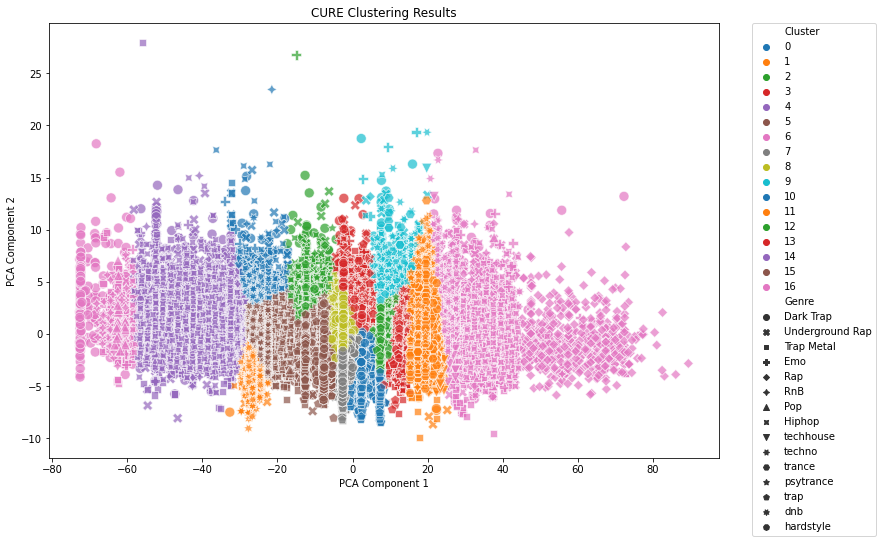

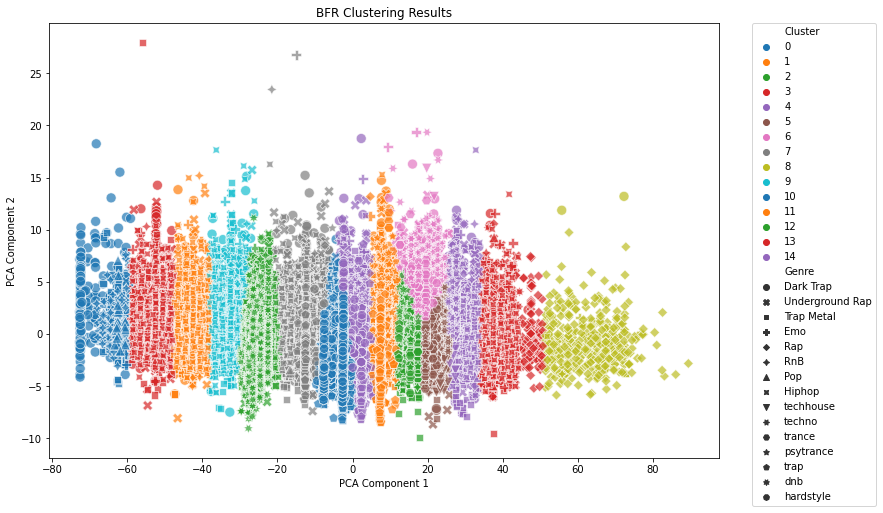

In [27]:
plot_pca_clusters(data, cure_labels, genres, title='CURE Clustering Results')
plot_pca_clusters(data, bfr_labels, genres, title='BFR Clustering Results')


MapReduce Based Kmeans Clustering

In [35]:
# Stop existing SparkContext if any
if 'sc' in locals():
    sc.stop()

# Initialize Spark Context
conf = SparkConf().setAppName("KMeans").setMaster("local")
sc = SparkContext(conf=conf)

In [36]:
data = sc.textFile("songs.csv").map(lambda line: line.split(","))
print(data.take(5))



[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'], ['0.831', '0.8140000000000001', '2', '-7.364', '1', '0.42', '0.0598', '0.0134', '0.0556', '0.389', '156.985', 'audio_features', '2Vc6NJ9PW9gD9q343XFRKx', 'spotify:track:2Vc6NJ9PW9gD9q343XFRKx', 'https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD9q343XFRKx', 'https://api.spotify.com/v1/audio-analysis/2Vc6NJ9PW9gD9q343XFRKx', '124539', '4', 'Dark Trap', 'Mercury: Retrograde', '', ''], ['0.7190000000000001', '0.493', '8', '-7.23', '1', '0.0794', '0.401', '0.0', '0.11800000000000001', '0.124', '115.08', 'audio_features', '7pgJBLVz5VmnL7uGHmRj6p', 'spotify:track:7pgJBLVz5VmnL7uGHmRj6p', 'https://api.spotify.com/v1/tracks/7pgJBLVz5VmnL7uGHmRj6p', 'https://api.spotify.com/v1/audio-analysis/7pgJBLVz5VmnL7uGHmRj6p', '224427', '4', 'Dar

In [28]:
# # Function to calculate Euclidean distance
# def euclidean_distance(point, centroid):
#     return np.sqrt(np.sum((np.array(point) - np.array(centroid)) ** 2))

# # Mapper function
# def mapper(data_point, centroids):
#     distances = [euclidean_distance(data_point[1:], centroid) for centroid in centroids]
#     min_distance_index = distances.index(min(distances))
#     return (min_distance_index, (data_point[1:], 1))

# # Reducer function
# def reducer(cluster_id, values):
#     sum_points = np.sum([value[0] for value in values], axis=0)
#     count = np.sum([value[1] for value in values])
#     new_centroid = sum_points / count
#     return (cluster_id, new_centroid)

# # Initialize centroids (this should be done across data centers collaboratively)
# k = 3  # number of clusters
# initial_centroids = [np.random.random((10,)) for _ in range(k)]

In [37]:

# max_iterations = 10  # Define the maximum number of iterations
# for _ in range(max_iterations):
#     # Mapper Phase
#     mapped_data = data.map(lambda point: mapper(point, initial_centroids))

#     # Reducer Phase
#     reduced_data = mapped_data.groupByKey().mapValues(list).mapValues(lambda points: reducer(_, points)).collect()

#     # Update centroids
#     new_centroids = [centroid for _, centroid in sorted(reduced_data, key=lambda x: x[0])]
    
#     # Check for convergence (if centroids do not change significantly)
#     if np.allclose(initial_centroids, new_centroids, atol=1e-4):
#         break
    
#     initial_centroids = new_centroids

# # Stop SparkContext
# sc.stop()